In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as ss
import scipy.special as ssp
import pymc as pm
import arviz as az
import pytensor.tensor as at
import pytensor.tensor.extra_ops as ate
import corner

# Create True Q

$$
q \sim N_{[0,1]}(\mu=1, \sigma=0.15)
$$

In [2]:
from scipy.stats import truncnorm

mut = 1.0
sigmat = 0.15
N = 10000

at = (0.0 - mut) / sigmat
bt = (1.0 - mut) / sigmat

q_true = truncnorm.rvs(at, bt, loc=mut, scale=sigmat, size=N)

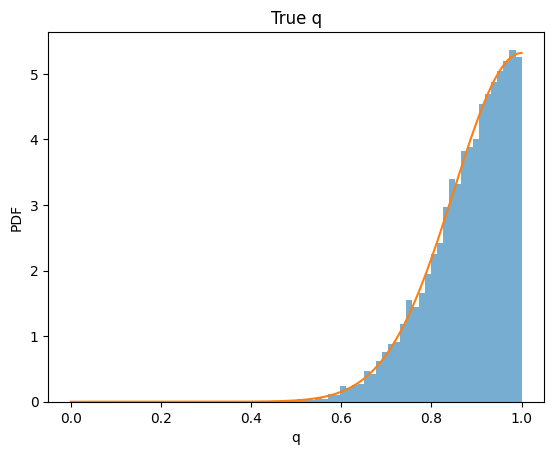

In [3]:
q_grid = np.linspace(0, 1, 500)
pdf = truncnorm.pdf(q_grid, at, bt, loc=mut, scale=sigmat)

plt.figure()
plt.hist(q_true, bins=50, density=True, alpha=0.6)
plt.plot(q_grid, pdf)
plt.xlabel("q")
plt.ylabel("PDF")
plt.title(r"True q")
plt.show()

# Inference with truth

$$
P(\mu, \sigma|\vec{q}_{true}) \propto \pi(\mu, \sigma) \prod_i^N N_{[0,1]}(q_{true}^i | \mu, \sigma)
$$

In [4]:
def make_model_true(q):
    q = np.asarray(q)
    with pm.Model() as model:        
        mu = pm.Uniform("mu", lower=0.0, upper=1.0)
        sigma = pm.Uniform("sigma", lower=0.1, upper=0.2)

        pm.TruncatedNormal("likelihood", mu=mu, sigma=sigma, lower=0.0, upper=1.0, observed=q)
    return model

In [5]:
with make_model_true(q_true) as model:
    trace = pm.sample(tune=2000, draws=2000, target_accept=0.9, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


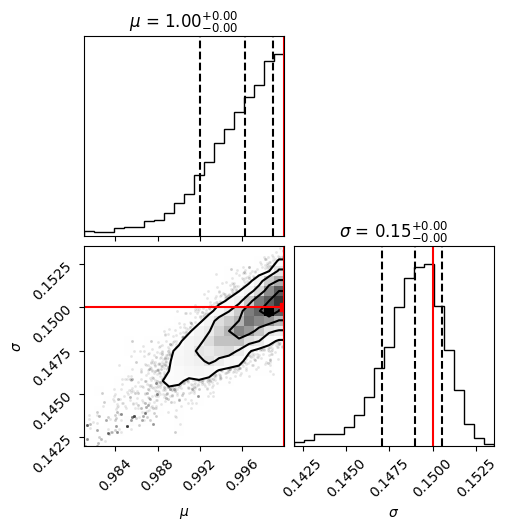

In [6]:
data = np.array([np.array(trace.posterior.mu).flatten(),np.array(trace.posterior.sigma).flatten()]).T
true = np.array([mut, sigmat])
figure = corner.corner(
    data,
    labels=[
        r"$\mu$",
        r"$\sigma$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

# Extract the axes
axes = np.array(figure.axes).reshape((len(true), len(true)))

# Loop over the diagonal
for i in range(len(true)):
    ax = axes[i, i]
    ax.axvline(true[i], color="r")



# Loop over the histograms
for yi in range(len(true)):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true[xi], color="r")
        ax.axhline(true[yi], color="r")
        ax.plot(true[xi], true[yi], "sr")

# Create Observed Q

$$
q_{obs} \sim N(\mu=q_{true}, \sigma_{obs}=0.1)
$$

such that $q_{true} \in [0,1]$ and $q_{obs} \in \mathcal{R}$.

In [11]:
sigmao = 0.1

q_obs = np.random.normal(loc=q_true, scale=sigmao, size=len(q_true))

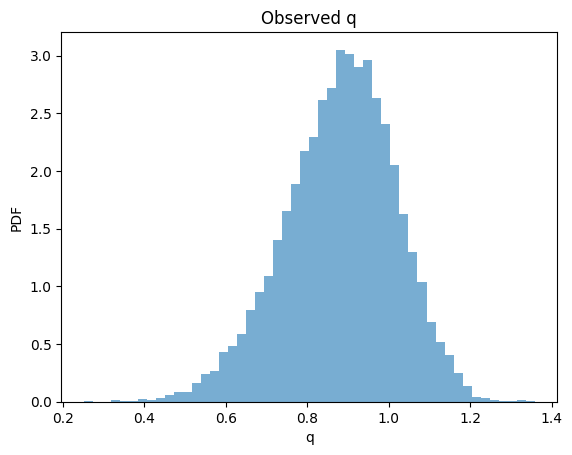

In [14]:
plt.hist(q_obs, bins=50, density=True, alpha=0.6)
plt.xlabel("q")
plt.ylabel("PDF")
plt.title(r"Observed q")
plt.show()

# Inference with observed

$$
P(\mu, \sigma|\vec{q}_{obs}) \propto \pi(\mu, \sigma) \prod_i^N \int_0^1 dq~N(q_{obs}^i | q, \sigma_{obs})~N_{[0,1]}(q | \mu, \sigma)
$$

$$
\propto \frac{N(q_{obs} | \mu, \sqrt{\sigma^2+\sigma_{obs}^2})}{\Phi\big(\frac{1-\mu}{\sigma}\big)-\Phi\big(-\frac{\mu}{\sigma}\big)}
$$

In [21]:
def make_model_obs(q, sigmao=0.1):
    q = np.asarray(q)
    N = q.size

    with pm.Model() as model:
        mu = pm.Uniform("mu", lower=0.0, upper=1.0)
        sigma = pm.Uniform("sigma", lower=0.1, upper=0.2)

        sigma_eff = pm.math.sqrt(sigma**2 + sigmao**2)

        std_norm = pm.Normal.dist(0.0, 1.0)
        
        logZ = pm.math.logdiffexp(pm.logcdf(std_norm, (1.0 - mu) / sigma), pm.logcdf(std_norm, -mu / sigma))
        pm.Potential("potential", -N * logZ)

        pm.Normal("likelihood", mu=mu, sigma=sigma_eff, observed=q)
        
    return model

In [22]:
with make_model_obs(q_obs) as model:
    trace = pm.sample(tune=2000, draws=2000, target_accept=0.9, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


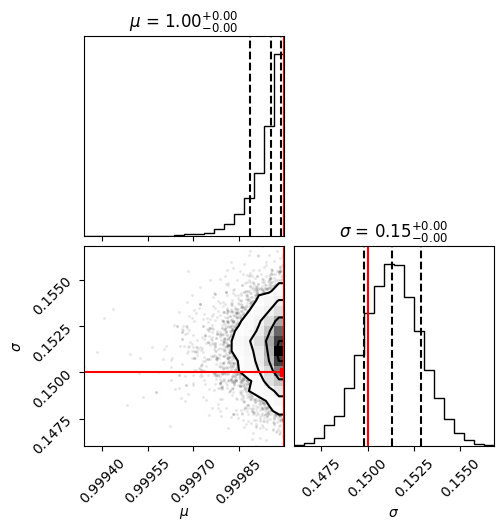

In [23]:
data = np.array([np.array(trace.posterior.mu).flatten(),np.array(trace.posterior.sigma).flatten()]).T
true = np.array([mut, sigmat])
figure = corner.corner(
    data,
    labels=[
        r"$\mu$",
        r"$\sigma$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

# Extract the axes
axes = np.array(figure.axes).reshape((len(true), len(true)))

# Loop over the diagonal
for i in range(len(true)):
    ax = axes[i, i]
    ax.axvline(true[i], color="r")



# Loop over the histograms
for yi in range(len(true)):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true[xi], color="r")
        ax.axhline(true[yi], color="r")
        ax.plot(true[xi], true[yi], "sr")